# Прогноз состава сырья
На нефтехимические заводы СИБУР сырье (широкая фракция легких углеводородов - ШФЛУ) поступает по трубопроводу. Трубопровод наполняется на нескольких станциях подкачки, которые расположены последовательно на пути к потребителю.

Состав ШФЛУ меняется на каждой станции с течением времени и, таким образом, меняется итоговый состав ШФЛУ, которую получает потребитель. Имея достоверный прогноз по составу можно оптимизировать некоторые технологические процессы.

Вам предстоит построить прогноз состава поступающей по трубопроводу ШФЛУ на основании данных с последней перед потребителем станции подкачки. При этом геометрия трубопровода, расстояние от станции подкачки до потребителя и другие параметры трубопровода не раскрываются.

Метрикой в этой задаче служит средняя по всем целевым переменным MAPE.

### Данные
Данные содержат расходы сырья в т/ч для станции подкачки A (A_rate) и потребителя B (B_rate), а также массовые процентные доли различных компонент на станции A (A_CH4, A_C2H6, A_C3H8, A_iC4H10, A_nC4H10, A_iC5H12, A_nC5H12, A_C6H14).

Целевые переменные: массовые процентные доли нескольких компонент на станции B (B_C2H6, B_C3H8, B_iC4H10, B_nC4H10). Целевые переменные для тестового периода не содержат разрывов, поэтому загружаемое решение должно содержать все временные метки из тестового множества.

train_targets.csv - целевые переменные для тренировочного множества
train_features.csv - признаки для тренировочного множества
test_features.csv - признаки для тестового множества
sample_submission.csv - пример решения в правильном формате

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
train_features = pd.read_csv('train_features.csv', header = 0, sep = ',')
test_features = pd.read_csv('test_features.csv', header = 0, sep = ',')
train_target = pd.read_csv('train_targets.csv', header = 0, sep = ',')

In [12]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 1000)

In [13]:
train_features

,timestamp,A_rate,A_CH4,A_C2H6,A_C3H8,A_iC4H10,A_nC4H10,A_iC5H12,A_nC5H12,A_C6H14,B_rate
0,2020-01-01 00:00:00,70.855017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.982789
1,2020-01-01 00:30:00,70.826582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.965098
2,2020-01-01 01:00:00,70.809637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.867409
3,2020-01-01 01:30:00,69.994748,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.839126
4,2020-01-01 02:00:00,70.072762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.336921
...,...,...,...,...,...,...,...,...,...,...,...
5803,2020-04-30 21:30:00,72.009730,0.284151,4.936343,35.758852,16.473834,24.318968,6.069360,5.527463,6.577563,74.183355
5804,2020-04-30 22:00:00,71.854180,0.282501,4.960453,35.877193,16.448487,24.074193,5.981357,5.407256,6.915378,74.213066
5805,2020-04-30 22:30:00,71.783273,0.277686,5.013878,36.271557,16.500147,24.010123,5.829363,5.160329,6.884173,74.144367
5806,2020-04-30 23:00:00,71.717743,0.271106,5.080144,36.616673,16.559533,24.008848,5.750492,5.017941,6.642076,74.320575


In [14]:
train_features.corr()

,A_rate,A_CH4,A_C2H6,A_C3H8,A_iC4H10,A_nC4H10,A_iC5H12,A_nC5H12,A_C6H14,B_rate
A_rate,1.000000,0.140528,0.437019,0.418836,0.017336,-0.430159,-0.399400,-0.367528,-0.318311,0.962491
A_CH4,0.140528,1.000000,0.335366,0.200776,-0.154180,-0.337805,-0.150923,-0.155106,-0.128191,0.051154
A_C2H6,0.437019,0.335366,1.000000,0.527549,-0.100987,-0.701938,-0.514814,-0.540416,-0.407348,0.341268
A_C3H8,0.418836,0.200776,0.527549,1.000000,0.486148,-0.709767,-0.940113,-0.930008,-0.881589,0.231222
A_iC4H10,0.017336,-0.154180,-0.100987,0.486148,1.000000,0.199295,-0.645688,-0.659884,-0.686246,-0.167036
A_nC4H10,-0.430159,-0.337805,-0.701938,-0.709767,0.199295,1.000000,0.546690,0.523956,0.384840,-0.273329
A_iC5H12,-0.399400,-0.150923,-0.514814,-0.940113,-0.645688,0.546690,1.000000,0.975426,0.862518,-0.224065
A_nC5H12,-0.367528,-0.155106,-0.540416,-0.930008,-0.659884,0.523956,0.975426,1.000000,0.877563,-0.178315
A_C6H14,-0.318311,-0.128191,-0.407348,-0.881589,-0.686246,0.384840,0.862518,0.877563,1.000000,-0.122962
B_rate,0.962491,0.051154,0.341268,0.231222,-0.167036,-0.273329,-0.224065,-0.178315,-0.122962,1.000000


In [15]:
train_features.describe()

,A_rate,A_CH4,A_C2H6,A_C3H8,A_iC4H10,A_nC4H10,A_iC5H12,A_nC5H12,A_C6H14,B_rate
count,5807.000000,4849.000000,4849.000000,4849.000000,4849.000000,4849.000000,4849.000000,4849.000000,4849.000000,5675.000000
mean,59.346948,0.159890,4.290739,37.990406,17.343168,24.413897,4.948636,4.809805,5.995740,64.817202
std,20.684895,0.068488,0.912565,3.756424,0.754301,1.274795,1.230539,1.285549,1.543956,10.696414
min,0.000321,0.008045,0.280524,11.345740,11.143152,18.655932,3.033678,1.338103,2.924722,0.000000
25%,61.846908,0.109331,3.971011,37.647968,17.018272,23.746663,4.462670,4.353103,5.574106,63.852030
50%,67.010148,0.139924,4.485758,38.618187,17.327200,24.138643,4.684908,4.619459,5.708216,68.583359
75%,69.734038,0.212163,4.844390,39.402360,17.685803,24.615843,5.086816,4.925770,6.032535,71.171153
max,74.560399,0.471429,6.418897,42.860283,20.353500,35.498867,13.812560,14.845480,30.656385,89.958390


In [16]:
train_features.isnull().values.any()

True

In [17]:
train_features.info()
train_features.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5808 entries, 0 to 5807
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  5808 non-null   object 
 1   A_rate     5807 non-null   float64
 2   A_CH4      4849 non-null   float64
 3   A_C2H6     4849 non-null   float64
 4   A_C3H8     4849 non-null   float64
 5   A_iC4H10   4849 non-null   float64
 6   A_nC4H10   4849 non-null   float64
 7   A_iC5H12   4849 non-null   float64
 8   A_nC5H12   4849 non-null   float64
 9   A_C6H14    4849 non-null   float64
 10  B_rate     5675 non-null   float64
dtypes: float64(10), object(1)
memory usage: 499.2+ KB


(5808, 11)

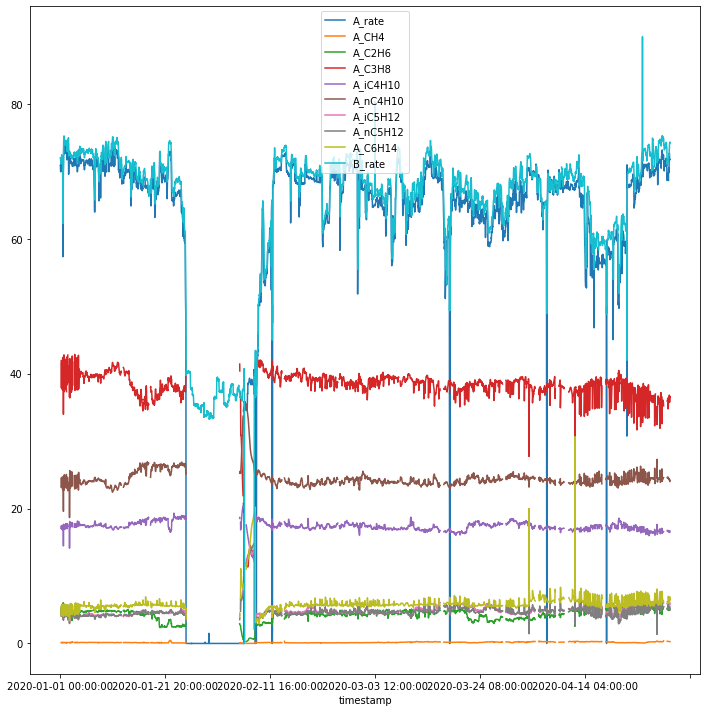

In [22]:
plt.rcParams["figure.figsize"] = (10,10)

train_features[:].plot('timestamp')

# make room for tick labels
plt.tight_layout()


plt.show()

In [19]:
train_features[train_features["A_rate"] <= 40]

,timestamp,A_rate,A_CH4,A_C2H6,A_C3H8,A_iC4H10,A_nC4H10,A_iC5H12,A_nC5H12,A_C6H14,B_rate
1197,2020-01-25 22:30:00,37.634787,0.068959,2.783333,39.613317,18.374810,25.521723,4.473425,3.987337,5.163005,45.833590
1198,2020-01-25 23:00:00,0.001294,0.070249,2.903388,41.168760,18.650220,25.298560,4.232059,3.601516,4.062176,42.446206
1199,2020-01-25 23:30:00,0.001701,0.071737,2.994731,41.935570,18.765710,25.119170,4.089573,3.390231,3.620386,39.727496
1200,2020-01-26 00:00:00,0.001525,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.972873
1201,2020-01-26 00:30:00,0.001055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.089745
1202,2020-01-26 01:00:00,0.001306,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.392475
1203,2020-01-26 01:30:00,0.002423,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.344998
1204,2020-01-26 02:00:00,0.001018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.335983
1205,2020-01-26 02:30:00,0.001185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.393765
1206,2020-01-26 03:00:00,0.000350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.240449


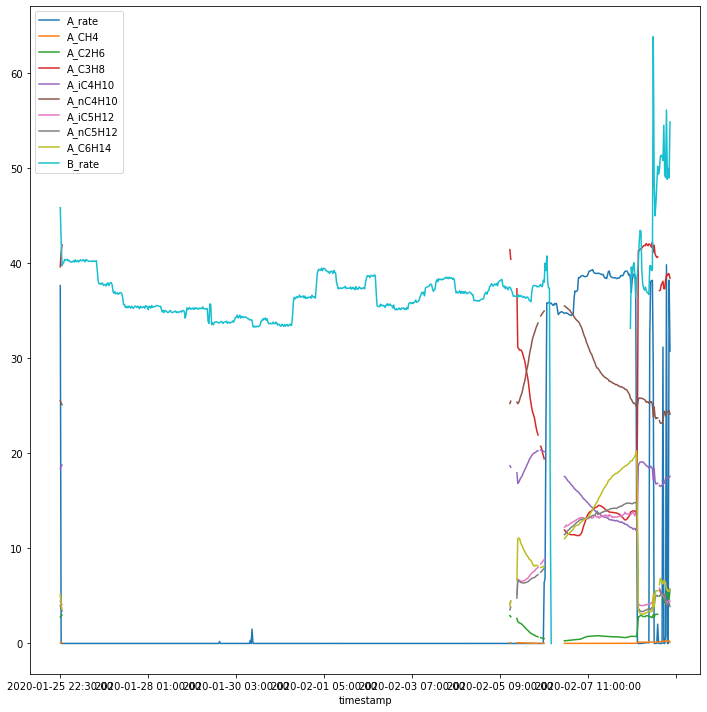

In [21]:
plt.rcParams["figure.figsize"] = (10,10)

train_features[train_features["A_rate"] <= 40].plot("timestamp")

# make room for tick labels
plt.tight_layout()


plt.show()

In [18]:
test_features

,timestamp,A_rate,A_CH4,A_C2H6,A_C3H8,A_iC4H10,A_nC4H10,A_iC5H12,A_nC5H12,A_C6H14,B_rate
0,2020-05-01 00:00:00,71.428342,0.267832,5.135159,36.816480,16.632260,24.062587,5.696004,4.939430,6.395286,74.273009
1,2020-05-01 00:30:00,70.925118,0.268464,5.149646,36.869023,16.651870,24.069800,5.676384,4.911872,6.346957,74.061833
2,2020-05-01 01:00:00,70.991719,0.270641,5.154615,37.074965,16.710967,24.106152,5.574873,4.808516,6.242636,73.856268
3,2020-05-01 01:30:00,70.972406,0.275241,5.230661,37.384180,16.683337,24.021993,5.514843,4.730887,6.101647,73.750744
4,2020-05-01 02:00:00,70.980078,0.275062,5.241437,37.448587,16.663863,24.003237,5.524898,4.728882,6.057119,73.698447
...,...,...,...,...,...,...,...,...,...,...,...
3979,2020-07-22 21:30:00,72.600912,0.120985,4.328092,40.875930,17.741460,24.098520,4.469224,3.619095,4.686205,75.486026
3980,2020-07-22 22:00:00,72.107049,0.110734,4.013567,38.871418,17.449352,24.049532,4.770699,3.988215,6.689777,75.370451
3981,2020-07-22 22:30:00,71.805799,0.111535,4.041506,39.794323,17.635380,24.169473,4.613603,3.790651,5.785216,74.985878
3982,2020-07-22 23:00:00,72.112046,0.119362,4.131432,40.461503,17.758833,24.211013,4.504242,3.657459,5.094626,74.766867


In [19]:
train_features.isnull().values.any()

True

In [20]:
test_features.info()
test_features.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3984 entries, 0 to 3983
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  3984 non-null   object 
 1   A_rate     2842 non-null   float64
 2   A_CH4      3528 non-null   float64
 3   A_C2H6     3533 non-null   float64
 4   A_C3H8     3532 non-null   float64
 5   A_iC4H10   3532 non-null   float64
 6   A_nC4H10   3532 non-null   float64
 7   A_iC5H12   3528 non-null   float64
 8   A_nC5H12   3528 non-null   float64
 9   A_C6H14    3529 non-null   float64
 10  B_rate     3979 non-null   float64
dtypes: float64(10), object(1)
memory usage: 342.5+ KB


(3984, 11)

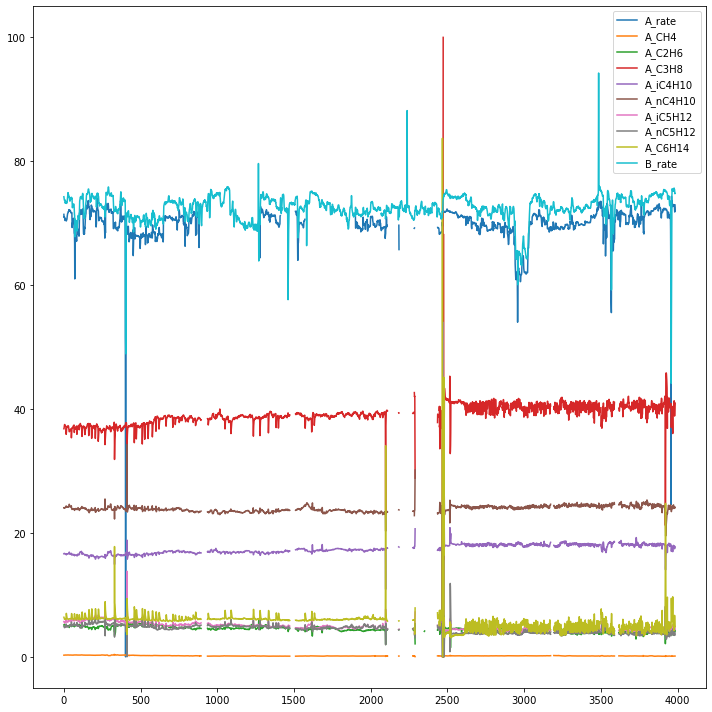

In [21]:
plt.rcParams["figure.figsize"] = (10,10)

test_features[:].plot()

# make room for tick labels
plt.tight_layout()


plt.show()

In [22]:
train_target

,timestamp,B_C2H6,B_C3H8,B_iC4H10,B_nC4H10
0,2020-01-01 00:00:00,4.561979,39.015486,17.250740,24.301793
1,2020-01-01 00:30:00,4.550741,39.048915,17.229506,24.257461
2,2020-01-01 01:00:00,4.506793,38.766378,17.171621,24.236298
3,2020-01-01 01:30:00,4.584963,39.069360,17.218521,24.149843
4,2020-01-01 02:00:00,4.607483,38.817579,17.108668,24.049510
...,...,...,...,...,...
5803,2020-04-30 21:30:00,4.816865,35.539156,16.269938,24.770377
5804,2020-04-30 22:00:00,4.993286,36.067750,16.317757,24.729847
5805,2020-04-30 22:30:00,5.101574,36.275040,16.295460,24.629889
5806,2020-04-30 23:00:00,5.210675,36.872917,16.336359,24.438236


In [23]:
train_features.isnull().values.any()

True

In [25]:
train_target.info()
train_target.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5808 entries, 0 to 5807
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  5808 non-null   object 
 1   B_C2H6     5624 non-null   float64
 2   B_C3H8     5628 non-null   float64
 3   B_iC4H10   5628 non-null   float64
 4   B_nC4H10   5628 non-null   float64
dtypes: float64(4), object(1)
memory usage: 227.0+ KB


(5808, 5)

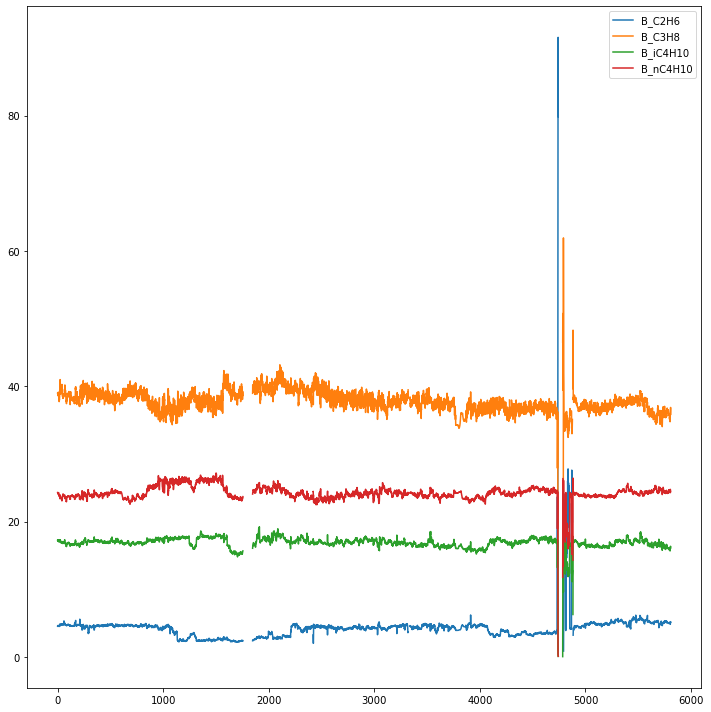

In [26]:
plt.rcParams["figure.figsize"] = (10,10)

train_target.plot()

# make room for tick labels
plt.tight_layout()


plt.show()

In [28]:
data = pd.concat([train_features,train_target.drop(['timestamp'], axis=1)], axis=1)
data.head()

,timestamp,A_rate,A_CH4,A_C2H6,A_C3H8,A_iC4H10,A_nC4H10,A_iC5H12,A_nC5H12,A_C6H14,B_rate,B_C2H6,B_C3H8,B_iC4H10,B_nC4H10
0,2020-01-01 00:00:00,70.855017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.982789,4.561979,39.015486,17.250740,24.301793
1,2020-01-01 00:30:00,70.826582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.965098,4.550741,39.048915,17.229506,24.257461
2,2020-01-01 01:00:00,70.809637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.867409,4.506793,38.766378,17.171621,24.236298
3,2020-01-01 01:30:00,69.994748,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.839126,4.584963,39.069360,17.218521,24.149843
4,2020-01-01 02:00:00,70.072762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.336921,4.607483,38.817579,17.108668,24.049510


In [38]:
monthList =[]
for i in data['timestamp']:
    monthList.append(int(str(i)[5:7]))

In [39]:
data['B_rate-A_rate'] = data['B_rate'] - data['A_rate']

In [40]:
data['month'] = monthList

In [41]:
data

,timestamp,A_rate,A_CH4,A_C2H6,A_C3H8,A_iC4H10,A_nC4H10,A_iC5H12,A_nC5H12,A_C6H14,B_rate,B_C2H6,B_C3H8,B_iC4H10,B_nC4H10,B_rate-A_rate,month
0,2020-01-01 00:00:00,70.855017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.982789,4.561979,39.015486,17.250740,24.301793,1.127772,1
1,2020-01-01 00:30:00,70.826582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.965098,4.550741,39.048915,17.229506,24.257461,1.138516,1
2,2020-01-01 01:00:00,70.809637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.867409,4.506793,38.766378,17.171621,24.236298,1.057772,1
3,2020-01-01 01:30:00,69.994748,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.839126,4.584963,39.069360,17.218521,24.149843,1.844378,1
4,2020-01-01 02:00:00,70.072762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.336921,4.607483,38.817579,17.108668,24.049510,1.264159,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5803,2020-04-30 21:30:00,72.009730,0.284151,4.936343,35.758852,16.473834,24.318968,6.069360,5.527463,6.577563,74.183355,4.816865,35.539156,16.269938,24.770377,2.173624,4
5804,2020-04-30 22:00:00,71.854180,0.282501,4.960453,35.877193,16.448487,24.074193,5.981357,5.407256,6.915378,74.213066,4.993286,36.067750,16.317757,24.729847,2.358885,4
5805,2020-04-30 22:30:00,71.783273,0.277686,5.013878,36.271557,16.500147,24.010123,5.829363,5.160329,6.884173,74.144367,5.101574,36.275040,16.295460,24.629889,2.361094,4
5806,2020-04-30 23:00:00,71.717743,0.271106,5.080144,36.616673,16.559533,24.008848,5.750492,5.017941,6.642076,74.320575,5.210675,36.872917,16.336359,24.438236,2.602832,4


In [60]:
data.columns

Index(['timestamp', 'A_rate', 'A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10',
       'A_nC4H10', 'A_iC5H12', 'A_nC5H12', 'A_C6H14', 'B_rate', 'B_C2H6',
       'B_C3H8', 'B_iC4H10', 'B_nC4H10', 'B_rate-A_rate', 'month'],
      dtype='object')

In [71]:
data.drop(labels=['timestamp','B_C2H6','B_C3H8', 'B_iC4H10', 'B_nC4H10'], axis=1).corrwith(data[['B_C2H6','B_C3H8', 'B_iC4H10', 'B_nC4H10']])

A_C2H6          NaN
A_C3H8          NaN
A_C6H14         NaN
A_CH4           NaN
A_iC4H10        NaN
A_iC5H12        NaN
A_nC4H10        NaN
A_nC5H12        NaN
A_rate          NaN
B_C2H6          NaN
B_C3H8          NaN
B_iC4H10        NaN
B_nC4H10        NaN
B_rate          NaN
B_rate-A_rate   NaN
month           NaN
dtype: float64

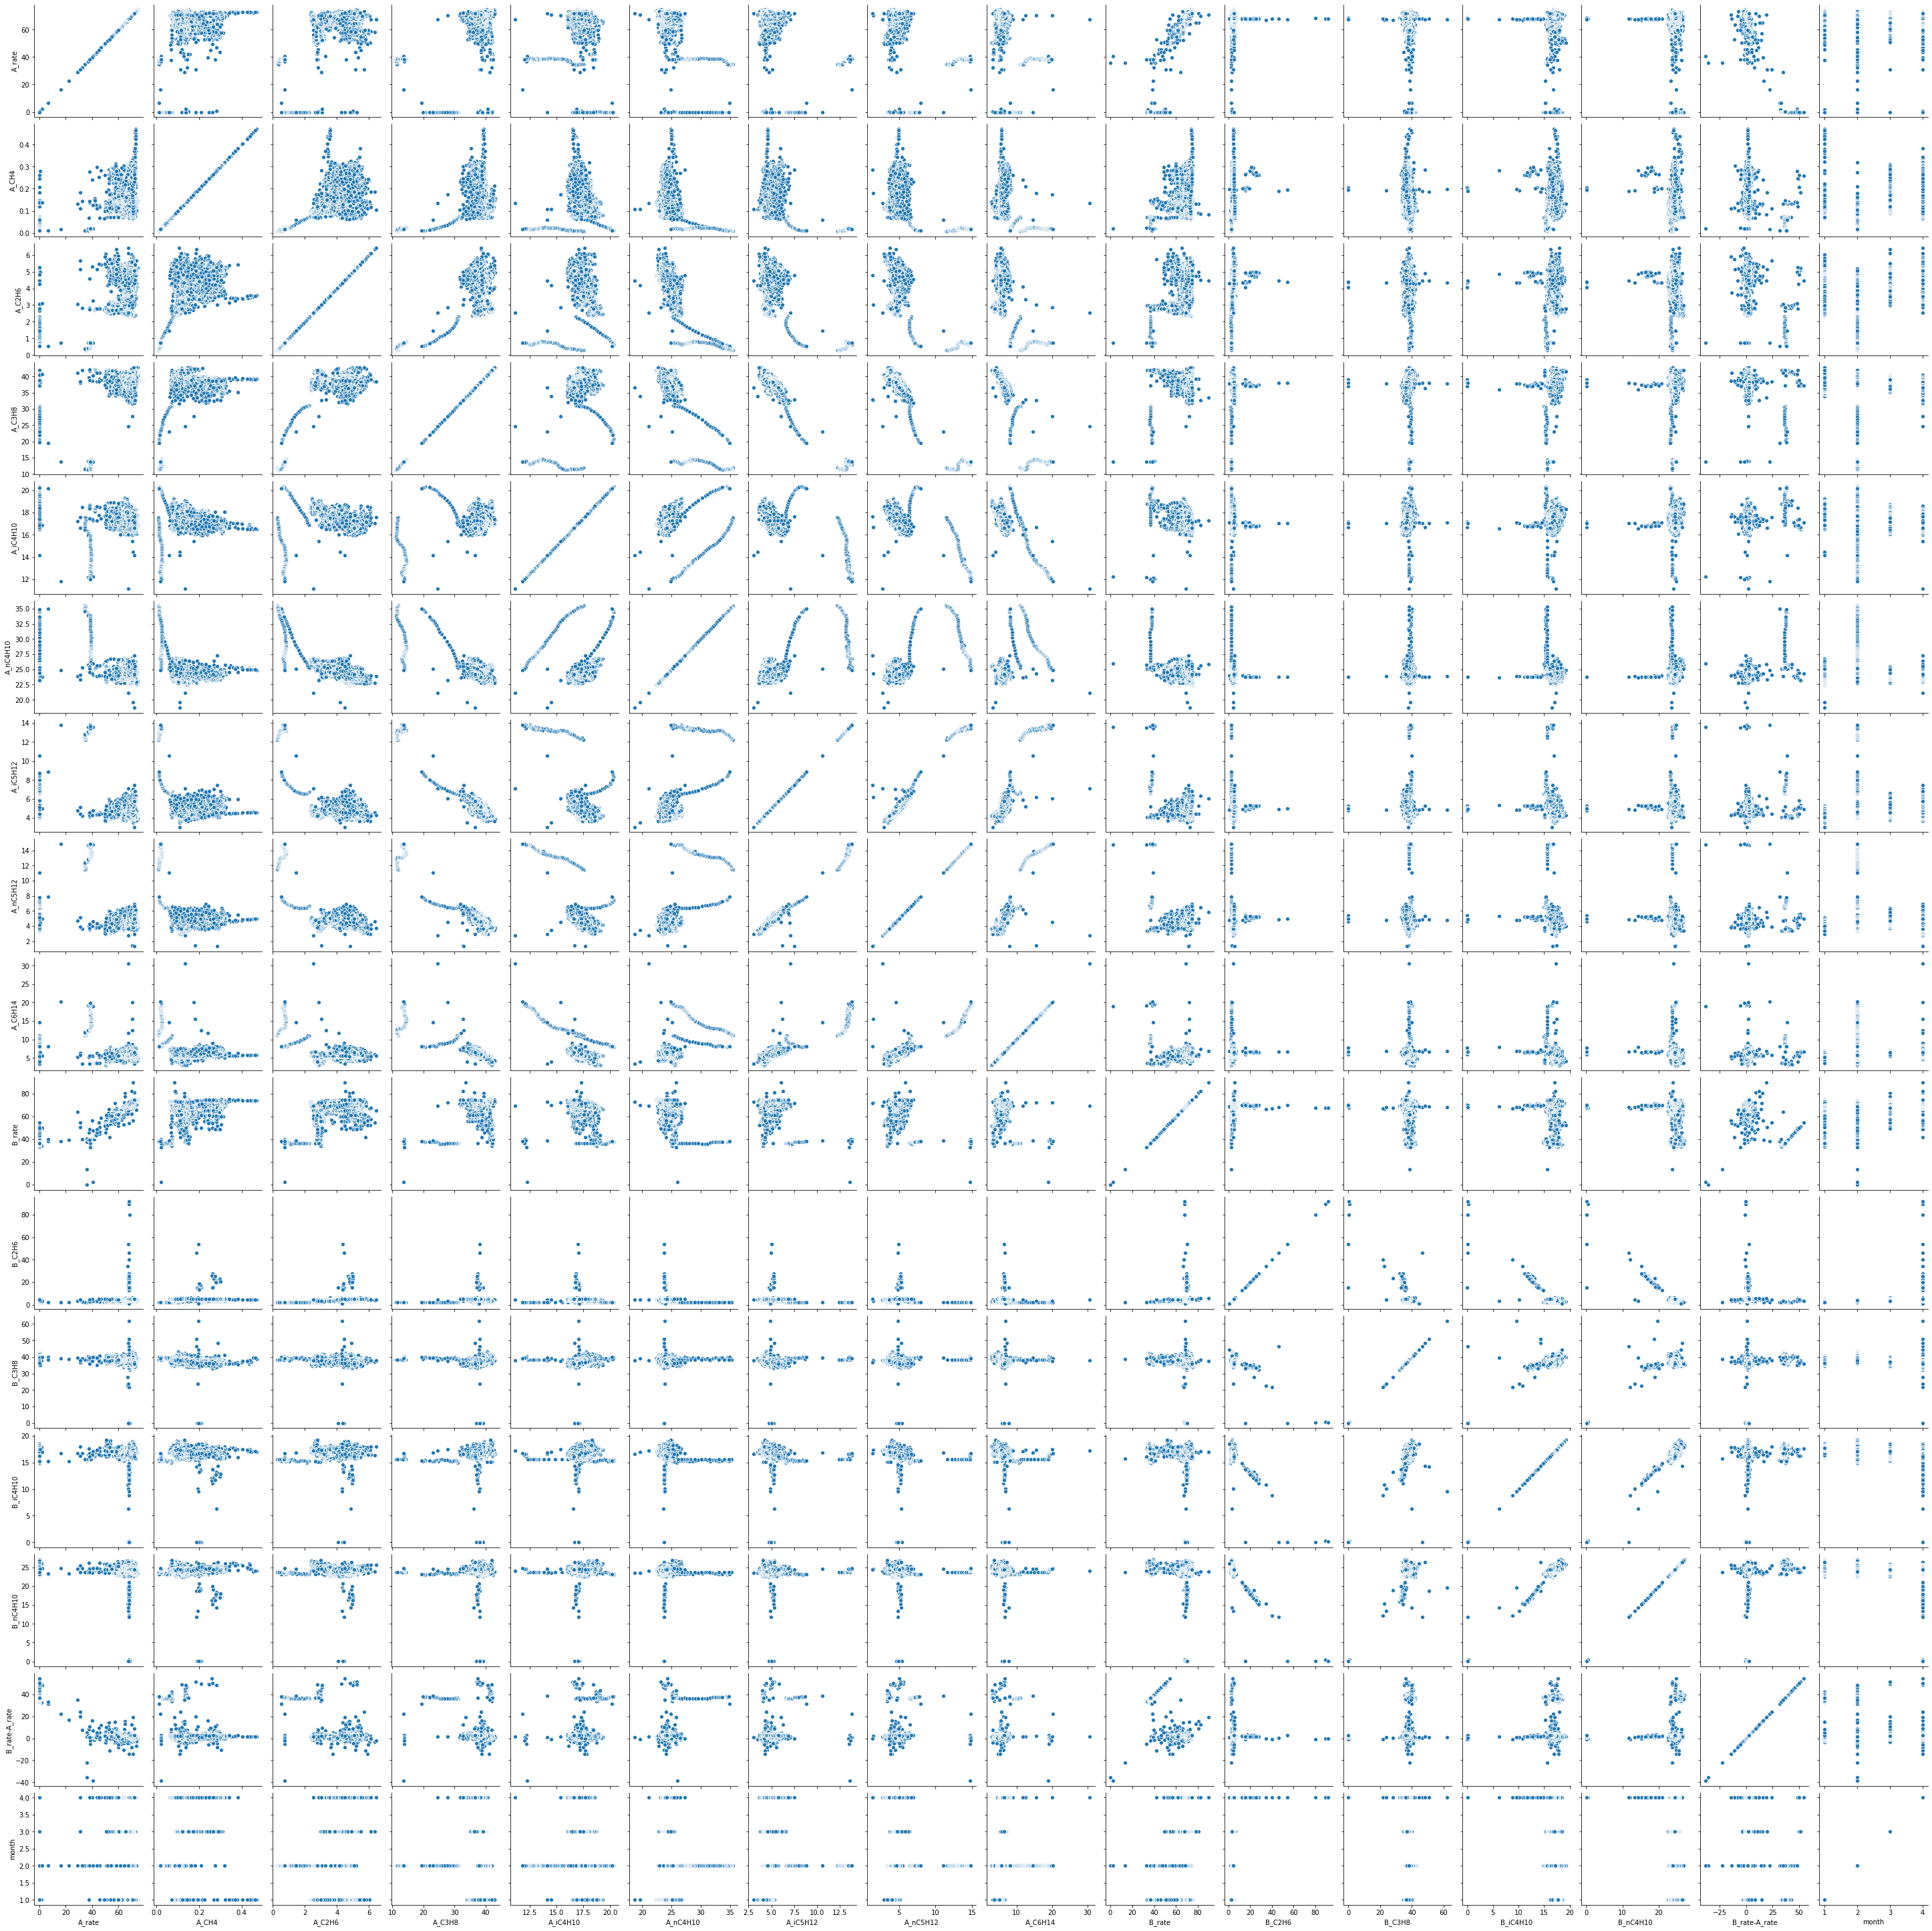

In [72]:
g = sns.PairGrid(data)
g.map(sns.scatterplot)